# CSC413 Assignment 2: American Sign Language

**Deadline**: March 9, 2023 by 6pm

**Submission**: Compile and submit a PDF report containing your code, outputs,
and your written solutions. Do not use screenshots and images to present
textual code/output (other than legible, hand-written answer).
You may export the completed notebook on Google Colab, but if you do so
**it is your responsibly to make sure that your code and answers do not get cut off**.

**Late Submission**: Please see the syllabus for the late submission criteria.

**Working with a partner**: You may work with a partner for this assignment.
If you decide to work with a partner, please create your group on Markus by
the deadline, even if you intend to use grace tokens. Markus does not allow
you to create groups past the deadline, even if you have grace tokens remaining.

[American Sign Language (ASL)](https://en.wikipedia.org/wiki/American_Sign_Language)
is a complete, complex language that employs signs made by 
moving the hands combined with facial expressions and postures of the body. 
It is the primary language of many North Americans who are deaf and is one of several 
communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabets are shown below.

In this assignment, we will 
classify a subset of these hand gesture images using convolutional neural networks.
Specifically, given an image of a hand showing one of the letters A-I, we want to detect
which letter is being represented.

We will explore several convolutional architectures.
While we will give you a tiny
big of starter code to help make data processing a bit easier,
you'll have a chance to build your neural network all by yourself!

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that your
TA can understand what you are doing and why.

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torchvision.models, torchvision.datasets


%matplotlib inline

## Question 1. Data

If you are using your own machine, download the data from the course website on Quercus.

If you are using Google Colab, download the data set to your Google Drive by going to
the link [https://drive.google.com/drive/folders/1aPL24P610NHLvt9exk6-B7SzGk3R8Q48?usp=sharing](https://drive.google.com/drive/folders/1aPL24P610NHLvt9exk6-B7SzGk3R8Q48?usp=sharing)
and selecting "Add to My Drive".
This is faster than downloading the data from the course website.

Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The file structure we use is intentional,
so that we can use `torchvision.datasets.ImageFolder`
to help load our data and create labels.

In [ ]:
train_path = "/content/gdrive/My Drive/CSC413/asl_data/train/" # edit me
valid_path = "/content/gdrive/My Drive/CSC413/asl_data/valid/" # edit me
test_path = "/content/gdrive/My Drive/CSC413/asl_data/test/"   # edit me

train_data = torchvision.datasets.ImageFolder(train_path, transform=torchvision.transforms.ToTensor())
valid_data = torchvision.datasets.ImageFolder(valid_path, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.ImageFolder(test_path, transform=torchvision.transforms.ToTensor())

### Part (a) -- 2 pts

Read up on what `torchvision.datasets.ImageFolder` does for us here
[https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder)

We can iterate through the one training data point at a time like this:

In [ ]:
for x, y in train_data:
    print(x.shape)
    print(y)
    break # uncomment if you'd like

torch.Size([3, 224, 224])
0


What do the variables `x` and `y` contain? What is the shape of our images?
What are our labels? How did PyTorch generate these labels from the folder structure?

Before answering this question, you will need to look at the folder structure
and look at some images in the data set.

In [ ]:
# Your explanation goes here:
# each x reperesents hte PyTorch tensor of a single image in the training set 
# each y is the respective label for the image

### Part (b) -- 2 pts

We saw in the earlier tutorials that PyTorch has a utility to help us
create minibatches with our data. We can use the same DataLoader helper
here:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

for x, y in train_loader:
    print(x.shape)
    print(y)
    break # uncomment if you'd like

torch.Size([10, 3, 224, 224])
tensor([5, 4, 2, 5, 0, 3, 0, 4, 0, 8])


What do the variables `x` and `y` contain? What are their shapes?
What data do they contain?

In [ ]:
# Your explanation goes here:
# each x is a Pytorch tensor of batch size (in our case, 10) images of the same shape as earlier (3, 224, 224)
# each y is a tensor with shape (batch size, 1) containing the respective label of each of the 10 images in the batch

### Part (c) -- 1 pts

How many images are there in the training, validation, and test sets?

In [ ]:
# Your answer (and possibly code) goes here:

print("Training set: {} images".format(len(train_data)))
print("validation set: {} images".format(len(valid_data)))
print("test set: {} images".format(len(test_data)))

Training set: 733 images
validation set: 207 images
test set: 223 images


### Part (d) -- 3 pts

This dataset was generated by students in past machine learning courses, where
each student took several photos of themselves demonstrating the ASL hand gestures.
The file names of the images follow the following convention:
`<student-identifier>_<letter>_<img-count>.jpg`

When we split the data into training, validation, and test sets, we took care
to put photos taken by the same person in the same data set. In other words, if one of the
student's photo is in the training set, then other photos taken by the same student
will also be placed in the training set.

This way of separating the dataset into training, validation and test is more nuanced
than simply randomly splitting the photos into training/validation/test.

Explain why it is important to make sure that we split the photos into the
three datasets **by student**, so that photos from the same student are always in the
same set.

In [ ]:
# Your answer goes here:

# The alternative to this is probably randomly splitting photos. This could result in one student's photos being in two or maybe even three folders
# ... training, validation and test folders. If we try to train with training set and then optimize with validation, the model may try to learn
# based on the characterstics of the student's hand and background of the photo and perform well on validation data with this since the same hand
# and background will be in validation data as well. We want to make sure that the set of hands in the validation data has never been seen by the
# model after training on the training set. The same goes for the test set.

# Another worry would be the random chance of a student getting many more photos in a particular folder than another student. This is a particularly
# big worry with such small batch sizes as an entire batch may contain only one student's photos and it feeds into the first problem I listed a
# little bit as well, which is that the model may try to learn to identify that student's photos rather than the actual goal of identifying
# ASL gestures.

## Question 2. Model Building

#### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts
the letter. Your model should be a subclass of `nn.Module`. 
You may want to review the Colab notebook demo from week 6 lectures. There is a small convolutional
neural network included in the notebook.

Here are some rules of thumb when determining your convolutional neural network architecture:

- Nowadays, people prefer small kernel sizes (e.g. 3x3 or 5x5), with many convolutional layers
  (we suggest 3-4 to start).
- Use a downsampling operation after (or with) each convolution layer
- In a typical convolutional neural network architectures, every time we downsample, we double the
  number of features (channels). This is so that we don't lose too much information in each layer.
  You may wish to make the number of output channels in your first convolutional layer a variable,
  and double this value in every subsequent convolutions.
- Typical CNNS will have a few (1-3) fully-connected layers as the final layers.

Explain your choice of neural network architecture: how many layers did you choose?
What types of layers did you use? Were they fully-connected or convolutional? What about other
decisions like pooling layers, activation functions, number of channels / hidden units.

Do not use dropout or batch normalization in this architecture.

In [ ]:
# Reasoning:
# In lecture we learned that convolutional layers are used to extract lower level features like edges and outlines which is important for
# image classification. As a result I start with conv layers, I chose three layers because I wanted to capture different levels of low level
# features and maybe find more abstract patterns in the data, but did not want to overdo it due to small data set. I went with the above suggested
# small kernel size of 3x3. The rule of thumb note above helped me choose ouput channel numbers. I start with 32 because it is a standard number
# for image data around this size and double it twice.

# Again following rule of thumb above I followed my convolution layers with a pooling layer to downsample and hopefully reduce overfitting chance
# by reducing the dimension of our features. I picked my pooling layer to be (2, 2) following the kernel size and stride values from the week 4
# conv_notebook example, again it fits our smaller data well I think.

# I started with 1 fully connected layer at the end but was worried it would not capture enough of the feature pattern with our flattened output
# from the previous layers so added another fully connected layer since this type of classification may be regarded as complex.

In [ ]:
# Your code goes here:

class ASLClassifier(nn.Module):
    def __init__(self, num_classes=9):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32,
                               kernel_size=3, padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128,
                               kernel_size=3, padding=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully Connected 
        self.fc1 = nn.Linear(in_features=128 * 28 * 28, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        
        # RELU
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = self.activation(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 28 * 28)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

#### Part (b) Convolutional Network with Batch Normalization - 3 pt

Build a variation of your convolutional neural network from part (a), and 
add either at least one batch normalization *or* at least one dropout layer,
but **not** both.
You will need to read the PyTorch documentation to figure out how these layers
function.

In [ ]:
# Exact same network as from part a but with a single dropout layer...
# From Pytorch documentation:

# During training, randomly zeroes some of the elements of the input tensor 
# with probability p using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every forward call.
# This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons as described in the paper 
# Improving neural networks by preventing co-adaptation of feature detectors.

# I went with a probability of 0.5 for the dropout following what was in the documentation ... this layer is inbetween the fully connected
# layers to randomly drop units in this layer and force the second fully connected layer to learn more abstract features.
# This accomplishes two things ideally, better feature learning and less overfitting

In [ ]:
# Your code goes here:

class ASLClassifierDropout(nn.Module):
    def __init__(self, num_classes=9):
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32,
                               kernel_size=3, padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128,
                               kernel_size=3, padding=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected 
        self.fc1 = nn.Linear(in_features=128 * 28 * 28, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        
        # Activation
        self.activation = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = self.activation(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 28 * 28)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)  # Add dropout layer here
        x = self.fc2(x)
        return x

#### Part (c) Architecture Decision - 1 pt

It does not make sense to add the batch normalization or dropout layer as
your *final* layer. Explain why this is the case.

In [ ]:
# Your answer goes here:

# Similar to the last part in my previous explanation, I think that the point of batch normalization or dropout is to throw some randomization
# into the model BEFORE the final layer finalizes its features and this would help prevent overfitting / improve performance. If we let the model
# learn everything and finalize the last layer AND THEN drop random units this would remove some of the nodes responsible for generating our output
# and that would have a big negative impact on our prediction accuracy.

## Question 3. Training Code and Sanity Checking

#### Part (a) Accuracy - 3 pt

Compute the `get_accuracy` function, which computes the model accuracy across a dataset:

In [ ]:
def get_accuracy(model, data):
    # note: why should we use a larger batch size here?
    loader = torch.utils.data.DataLoader(data, batch_size=256)

    model.eval() # annotate model for evaluation (why do we need to do this?)

    correct = 0
    total = 0
    for imgs, labels in loader:
        # pass # TODO
        preds = model(imgs)
        predicted = torch.argmax(preds, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).int().sum().item()


    return correct / total # TODO: return the model accuracy

#### Part (b) Training Code - 8 pt

Write code to train your neural network given some training data. Your training code
should make it easy to tweak hyperparameters. Make sure that you are checkpointing
your models from time to time (the frequency is up to you). 

Here's what we will be looking for:

- using the data loader to load the training data
- using the correct choice of loss function and a reasonable optimizer
- shuffling the training data at the start of each epoch
- in each iteration, take `batch_size` samples from the data set
- use the correct labels from the data set
- computing the forward and backward passes
- after every epoch, **checkpoint your model** (A1 had instructions and examples for how to do this)
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and **plot the training curve**
- correctly handling edge cases (e.g. why might the last batch be smaller than the rest?)

Don't forget the checkpointing step. You will need to load your model weights later.

In [ ]:
# Your code goes here

# You can use this function header, but don't have to:

# I am using the given function header with the addition of a checkpoint path
def train(model, train_data, valid_data, batch_size=32, weight_decay=0.0,
           learning_rate=0.001, num_epochs=7, checkpoint_path=None):
     
     # Following the steps above of what will be looked for in this code:
     # using the data loader to load the training data
     train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
     valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

     # using the correct choice of loss function and a reasonable optimizer
     # I will use CE loss because this is a multi-classification problem and
     # we have only talked about Adam optimizer in lectures so far (for the most part)
     criterion = nn.CrossEntropyLoss()
     optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

     # shuffling the training data at the start of each epoch 
     # this is done by setting shuffle to True in the train_loader

     # Initialize our tracking lists
     train_losses = []
     valid_losses = []
     train_accs = []
     valid_accs = []
     best_valid_acc = 0.0
     for epoch in range(num_epochs):
         model.train()
         # reset this every epoch
         total_loss = 0
         num_correct = 0

         # in each iteration, take batch_size samples from the data set
         # we will do this here by iterating through our train_loader which is already
         # set up with our batch_size
         for imgs, labels in train_loader:
            # reset our gradients every iteration of this
            optimizer.zero_grad()

            # computing the forward and backward passes
            # forward pass:
            preds = model(imgs)
            # use the correct labels from the data set
            loss = criterion(preds, labels)

            # backward pass:
            loss.backward()
            optimizer.step()

            # update loss and num_correct after the passes
            # similar to method used in the accuracy function
            total_loss += loss.item() * imgs.size(0)
            f_preds = torch.argmax(preds.data, 1)
            num_correct += (f_preds == labels).sum().item()

         # calculate training loss and accuracy for each epoch and update lists
         train_loss = loss / len(train_data)
         train_acc = num_correct / len(train_data)
         train_losses.append(train_loss)
         train_accs.append(train_acc)
         
         model.eval()
         # reset our variables and begin validation
         total_loss = 0
         num_correct = 0

         for imgs, labels in valid_loader:
           # forward pass
           preds = model(imgs)
           loss = criterion(preds, labels)

           # update loss and num_correct after the pass
           total_loss += loss.item() * imgs.size(0)
           f_preds = torch.argmax(preds.data, 1)
           num_correct += (f_preds == labels).sum().item()
        
         # calculate training loss and accuracy for each epoch and update lists
         valid_loss = total_loss / len(valid_data)
         valid_acc = num_correct / len(valid_data)
         valid_losses.append(valid_loss)
         valid_accs.append(valid_acc)


         # after every epoch, report the accuracies for the training set and validation set
         print("Epoch {}/{}   Train Acc: {:.4f}   Valid Acc: {:.4f}\n"
              .format(epoch+1, num_epochs, train_acc, valid_acc))
         
         # after every epoch, checkpoint your model (A1 had instructions and examples for how to do this)
         # this is mostly copied from the A1 code
         if (checkpoint_path is not None):
              # where ... checkpoint_path = '/content/gdrive/My Drive/CSC413/ASL_ckpts/ckpt-{}.pk'
              torch.save(model.state_dict(), checkpoint_path.format(epoch+1))

     # track the training curve information and plot the training curve
     #plt.title("Learning Curve: Loss per Iteration")
     #plt.plot(train_losses, label="Train Loss")
     #plt.show()

     plt.title("Learning Curve: Loss per Iteration")
     plt.plot(train_accs, label="Train Loss")
     plt.plot(valid_accs, label="Validation Loss")
     plt.xlabel("Iterations")
     plt.ylabel("Loss")
     plt.legend()
     plt.show()
     
     return train_loss, valid_loss

    # correctly handling edge cases (e.g. why might the last batch be smaller than the rest?)
    # I am not exactly sure about the details of this but according to the DataLoader documentation
    # https://mmcv.readthedocs.io/en/v1.5.2_a/_modules/torch/utils/data/dataloader.html
    # The dataloader object automatically drops the last batch if the size is not a multiple of 
    # batch size ... so if it is incomplete.

    
    

#### Part (c) Overfit to a Small Dataset - 2 pt

One way to sanity check our neural network model and training code is to check whether 
each of your two models is capable of "memorizing" or "overfitting" to a small dataset. Construct
a small dataset (e.g. 1-2 image per class). Then show that your model and training code
is capable of overfitting on that small dataset. You should be able to obtain a 100% 
training accuracy on that small dataset relatively quickly (i.e. within a few hundred iterations,
possibly more depending on your learning rate).

This question is really here to make sure that your model/training code is correct.
The question itself is not worth much, but your results here will diagnose issues
from other parts of your code.
If your models cannot overfit the small dataset quickly, then there is
a bug in either your model code and/or your training code. Fix the issues
before you proceed to the next step.

Epoch 1/20   Train Acc: 0.0556   Valid Acc: 0.1111

Epoch 2/20   Train Acc: 0.1111   Valid Acc: 0.1111

Epoch 3/20   Train Acc: 0.1667   Valid Acc: 0.1667

Epoch 4/20   Train Acc: 0.3333   Valid Acc: 0.1667

Epoch 5/20   Train Acc: 0.3333   Valid Acc: 0.1111

Epoch 6/20   Train Acc: 0.3889   Valid Acc: 0.1111

Epoch 7/20   Train Acc: 0.5556   Valid Acc: 0.2778

Epoch 8/20   Train Acc: 0.6111   Valid Acc: 0.1667

Epoch 9/20   Train Acc: 0.5556   Valid Acc: 0.1667

Epoch 10/20   Train Acc: 0.5000   Valid Acc: 0.2222

Epoch 11/20   Train Acc: 0.6111   Valid Acc: 0.1667

Epoch 12/20   Train Acc: 0.5556   Valid Acc: 0.1667

Epoch 13/20   Train Acc: 0.5000   Valid Acc: 0.1667

Epoch 14/20   Train Acc: 0.5000   Valid Acc: 0.1111

Epoch 15/20   Train Acc: 0.6667   Valid Acc: 0.2778

Epoch 16/20   Train Acc: 0.6111   Valid Acc: 0.1667

Epoch 17/20   Train Acc: 0.7222   Valid Acc: 0.3333

Epoch 18/20   Train Acc: 0.6111   Valid Acc: 0.2222

Epoch 19/20   Train Acc: 0.6111   Valid Acc: 0.2222

Ep

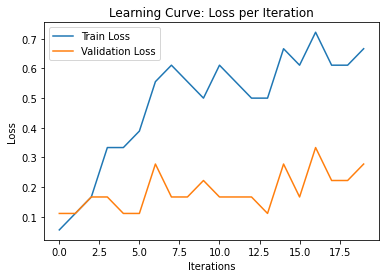

(tensor(0.1189, grad_fn=<DivBackward0>), 2.1290982564290366)

In [ ]:
# Your code goes here:
# I could not find the right hyperparameters for the small dataset

small_train_path = "/content/gdrive/My Drive/CSC413/asl_small/train/"
small_valid_path = "/content/gdrive/My Drive/CSC413/asl_small/valid/"

small_train_data = torchvision.datasets.ImageFolder(small_train_path, transform=torchvision.transforms.ToTensor())
small_valid_data = torchvision.datasets.ImageFolder(small_valid_path, transform=torchvision.transforms.ToTensor())

model = ASLClassifier(num_classes=9)

train(model, small_train_data, small_valid_data, learning_rate=0.00001, batch_size=2, num_epochs=20)

## Question 4. Training

### Part (a) -- 5 points

Train your first network on your training set.
Plot the training curve, and include your plot in your writeup.

Make sure that you are checkpointing frequently!

Epoch 1/10   Train Acc: 0.1228   Valid Acc: 0.2126

Epoch 2/10   Train Acc: 0.2960   Valid Acc: 0.6184

Epoch 3/10   Train Acc: 0.5757   Valid Acc: 0.6715

Epoch 4/10   Train Acc: 0.7408   Valid Acc: 0.7488

Epoch 5/10   Train Acc: 0.8145   Valid Acc: 0.6957

Epoch 6/10   Train Acc: 0.8540   Valid Acc: 0.7536

Epoch 7/10   Train Acc: 0.8827   Valid Acc: 0.7391

Epoch 8/10   Train Acc: 0.8909   Valid Acc: 0.8068

Epoch 9/10   Train Acc: 0.9345   Valid Acc: 0.8068

Epoch 10/10   Train Acc: 0.9427   Valid Acc: 0.8164



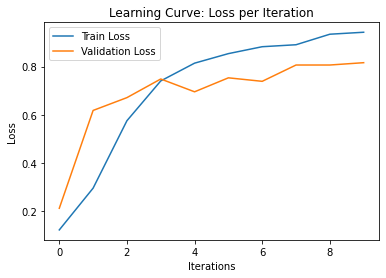

In [ ]:
# Your code goes here. Make sure to include the training curve.

model = ASLClassifier()
batch_size = 32
weight_decay = 0.001
learning_rate = 0.001
num_epochs = 10

train_loss, valid_loss = train(model, train_data, valid_data, batch_size=batch_size, weight_decay=weight_decay,
                               learning_rate=learning_rate, num_epochs=num_epochs, checkpoint_path='/content/gdrive/My Drive/CSC413/ASL_ckpts/ckpt-{}.pk')

### Part (b) -- 2 points

You should have tried several hyperparameter choices before deciding on one set
of hyperparameters to use for Part (a).
In this section, briefly explain the hyperparamter choices that you tried, 
and how they impacted your training.

In [ ]:
# Your explanation goes here:
# After running this and traning a few times these are the hyperparameters that worked:

# Learning Rate: Tested rates between 0.0001 to 0.1 and 0.001 gave me the best results for the combination
# of traning and validation accuracy

# Batch Size: I tried a smaller batch size of 8 but it was taking a longer time and gradient seemed to be jumping
# around a bit more so I stuck with 32, did not want to go higher with a smaller dataset.

# epochs: Accuracy started jumping around a bit at around 10 epochs so I stuck to 10, I did not get much improvement after that

# Weight decay: I played around with ranges between 0.01 all the way to 0, many gave similar results but 0.001
# was one of the best.

### Part (c) -- 5 points

Train your second network on your training set.
Plot the training curve, and include your plot in your writeup.

Make sure that you are checkpointing frequently!

Epoch 1/15   Train Acc: 0.1241   Valid Acc: 0.2705

Epoch 2/15   Train Acc: 0.3397   Valid Acc: 0.5749

Epoch 3/15   Train Acc: 0.5593   Valid Acc: 0.6763

Epoch 4/15   Train Acc: 0.7053   Valid Acc: 0.6908

Epoch 5/15   Train Acc: 0.7531   Valid Acc: 0.7440

Epoch 6/15   Train Acc: 0.7913   Valid Acc: 0.7343

Epoch 7/15   Train Acc: 0.8240   Valid Acc: 0.7633

Epoch 8/15   Train Acc: 0.8581   Valid Acc: 0.7488

Epoch 9/15   Train Acc: 0.8499   Valid Acc: 0.7391

Epoch 10/15   Train Acc: 0.8649   Valid Acc: 0.7729

Epoch 11/15   Train Acc: 0.9195   Valid Acc: 0.7874

Epoch 12/15   Train Acc: 0.9291   Valid Acc: 0.7874

Epoch 13/15   Train Acc: 0.9263   Valid Acc: 0.7778

Epoch 14/15   Train Acc: 0.9209   Valid Acc: 0.7778

Epoch 15/15   Train Acc: 0.9318   Valid Acc: 0.8019



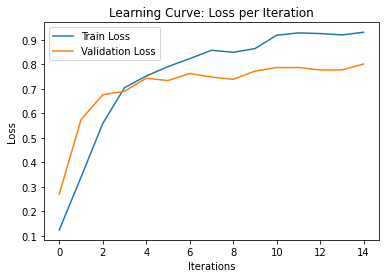

In [ ]:
# Your code goes here. Make sure to include the training curve.

model = ASLClassifierDropout()
batch_size = 32
weight_decay = 0.001
learning_rate = 0.001
num_epochs = 15

train_loss, valid_loss = train(model, train_data, valid_data, batch_size=batch_size, weight_decay=weight_decay,
                               learning_rate=learning_rate, num_epochs=num_epochs, checkpoint_path='/content/gdrive/My Drive/CSC413/ASL_ckpts/DOckpt-{}.pk')

### Part (d) -- 2 points

You should have tried several hyperparameter choices before deciding on one set
of hyperparameters to use for Part (c).
In this section, briefly explain the hyperparamter choices that you tried, 
and how they impacted your training.

In [ ]:
# Your explanation goes here:
# I played around a bit but ended up with the exact same approach as the last model. when I tried using the
# same values I actually got the best results, probably because the models are very similar just with the addition
# of dropout .... where the default recommended value of 0.5 worked best for the model.
# The only other thing that changed was number of epochs

# Your explanation goes here:
# After running this and traning a few times these are the hyperparameters that worked:

# Learning Rate: Tested rates between 0.0001 to 0.1 and 0.001 gave me the best results for the combination
# of traning and validation accuracy

# Batch Size: I tried a smaller batch size of 8 but it was taking a longer time and gradient seemed to be jumping
# around a bit more so I stuck with 32, did not want to go higher with a smaller dataset.

# epochs: I got diminishing returns after around 15 and less than that it was not finished optimizing

# Weight decay: I played around with ranges between 0.01 all the way to 0, many gave similar results but 0.001
# was one of the best.

### Part (e) -- 1 pts

Out of all the models (i.e. parts (a) vs (c), and the various hyperparameter choices)
that you tried, which model is the "best"?
If you were to select a single set of weight values (checkpoints)
to deploy and use in a real application, which would you choose?

In [ ]:
# Your explanation goes here:

# So far my best results came from the last epoch of my dropout model both for training and validation
# accuracy so that is the checkpoint I would deploy at this point. Below I will outline a summary of this
# model and its weights using the summary method from the torch documentation:
# Documentation ---> https://pypi.org/project/torch-summary/

partE = ASLClassifierDropout()
partE.load_state_dict(torch.load('/content/gdrive/My Drive/CSC413/ASL_ckpts/DOckpt-15.pk'))
summary(partE, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Linear-10                  [-1, 512]      51,380,736
             ReLU-11                  [-1, 512]               0
          Dropout-12                  [-1, 512]               0
           Linear-13                    [-1, 9]           4,617
Total params: 51,478,601
Trainable para

## Question 5. Transfer Learning

For many image classification tasks, it is generally not a good idea to train a
very large deep neural network model from scratch due to the enormous compute
requirements and lack of sufficient amounts of training data.

One of the better options is to try using an existing model that performs a
similar task to the one you need to solve. This method of using a
pre-trained network for other similar tasks is broadly termed
**Transfer Learning**. In this question, we will use Transfer Learning
to extract features from the hand gesture images. Then, train a smaller
network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, the AlexNet architecture played a pivotal role in
establishing Deep Neural Nets as a go-to tool for image classification
problems and we will use an ImageNet pre-trained AlexNet model to
extract features in this assignment.

### Part (a)

Here is the code to load the AlexNet network, with pretrained weights.
When you first run the code, PyTorch will download the pretrained weights
from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

The `alexnet` model is split up into two components: `alexnet.features` and 
`alexnet.classifier`.  The first neural network component, `alexnet.features`,
is used to
computed convolutional features, which is taken as input in `alexnet.classifier`.

The neural network `alexnet.features` expects an image tensor of shape
Nx3x224x224 as inputs and it will output a tensor of shape Nx256x6x6 . (N = batch size).

Here is an example code snippet showing how you can compute the AlexNet
features for some images (your actual code might be different):

In [ ]:
img, label = train_data[0]
features = alexnet.features(img.unsqueeze(0)).detach()

Note that the `.detach()` at the end will be necessary in your code. The reason is that
PyTorch automatically builds computation graphs to be able to backpropagate
gradients. If we did not explicitly "detach" this tensor from the AlexNet portion
of the computation graph, PyTorch might try to backpropagate gradients to the AlexNet
weight and tune the AlexNet weights.

Compute the AlexNet features for each of your training, validation, and test data.
In other words, create three new arrays called `train_data_features`, `valid_data_features`
and `test_data_features`. Each of these arrays should contain tuples of the form 
`(alexnet_features, label)`

In [ ]:
# Modify this code

train_data_features = []
for img, y in train_data:
    features = alexnet.features(img.unsqueeze(0)).detach()
    train_data_features.append((features, y))

valid_data_features = []
for img, y in valid_data:
    features = alexnet.features(img.unsqueeze(0)).detach()
    valid_data_features.append((features, y))

test_data_features = []
for img, y in test_data:
    features = alexnet.features(img.unsqueeze(0)).detach()
    test_data_features.append((features, y))

### Part (b)


Create a multi-layer preceptron that
takes **as input** these AlexNet features,
and makes a prediction. Your model should be a subclass of `nn.Module`.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

### Part (c)

Train the `MLP()` model for at least 6 epochs, and report
on the maximum validation accuracy that you can attain.

This model should train *much* faster since it has very few parameters.
However, this model should attain much better accuracy much faster!

Epoch 1/6   Train Acc: 0.6453   Valid Acc: 0.8502

Epoch 2/6   Train Acc: 0.9659   Valid Acc: 0.9179

Epoch 3/6   Train Acc: 0.9905   Valid Acc: 0.9275

Epoch 4/6   Train Acc: 0.9986   Valid Acc: 0.9324

Epoch 5/6   Train Acc: 1.0000   Valid Acc: 0.9420

Epoch 6/6   Train Acc: 1.0000   Valid Acc: 0.9565



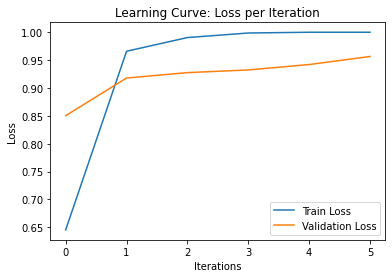

In [ ]:
mlp = MLP()
train_losses, valid_losses = train(mlp, train_data_features, valid_data_features, num_epochs=6)

In [ ]:
# Max Validation accuracy of 95.65%

## Question 6. Test Accuracy

### Part (a) -- 5 pts

Report the test accuracies of your **single best** model for the test set, including
any model that you trained (including in Q5).

In [ ]:
# Write your code here. Make sure to include the test accuracy in your report
test_acc = get_accuracy(mlp, test_data_features)
print("Test Accuracy: {:.4f}".format(test_acc))

Test Accuracy: 0.8072


### Part (b) -- 1 pts

Display one image that your model correctly classified.

tensor([True])
Our model predicted: 5
Actual label is: 5


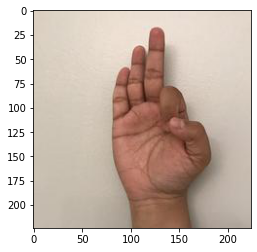

In [ ]:
# Make sure both your code and image are visible to the TA
image, label = test_data[129]

features = alexnet.features(image.unsqueeze(0)).detach()
output = mlp(features)
pred = torch.argmax(output, dim=1)

print(pred == label)
print ("Our model predicted: {}".format(pred[0]))
print("Actual label is: {}".format(label))

plt.imshow(image.permute(1, 2, 0));

### Part (b) -- 1 pts

Display one image that your model incorrectly classified. (If your test performance was 100%, please just say so.)

tensor([False])
Our model predicted: 6
Actual label is: 0


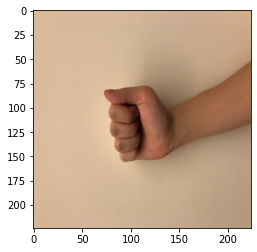

In [ ]:
# Make sure both your code and image are visible to the TA
image, label = test_data[12]

features = alexnet.features(image.unsqueeze(0)).detach()
output = mlp(features)
pred = torch.argmax(output, dim=1)

print(pred == label)
print ("Our model predicted: {}".format(pred[0]))
print("Actual label is: {}".format(label))

plt.imshow(image.permute(1, 2, 0));

## Question 6. Adversarial Examples -- 2 pts

In this question you will take the trained model you selected in Q4 (e),
and you will freeze its weights (i.e. do not optimize it further). Let's call this model $f()$.
Select an image (let's call it $x$) from the test set, where $f(x)$ outputs the correct label $y$.
Then, compute an adversarial noise image (let's call it $n$) that you will add to $x$ in order to change
the original label to an incorrect one, i.e. $f(x + n) \neq f(x)$, while keeping the value of the noise
pixels small, i.e. $|n_{i,j}| < \epsilon$. You have control over $\epsilon$, but keep in mind that the
noise should be imperceptible to the human eye when not zooming into the image.

In [ ]:
#
# Make sure your code, original image x, and the corrupted image x + n are shown to the TA
# Show the output f(x) = y and the output f(x + n) is different than y.
#

f = ASLClassifierDropout()
f.load_state_dict(torch.load('/content/gdrive/My Drive/CSC413/ASL_ckpts/DOckpt-15.pk'))

x, y = test_data[20]

f_x = f(x)
f_x = torch.argmax(f_x, dim=1)

print(f_x == y)

tensor([True])


In [ ]:
# Im not sure how to approach this at the moment

## Question 7. Work Allocation -- 1 pts

This question is to make sure that if you are working with a partner, that
you and your partner contributed equally to the assignment.

Please have each team member write down the times that you worked on the
assignment, and your contribution to the assignment.

In [ ]:
# Your answer goes here:
# Worked alone